# Modelos con splits

#### Librerias

In [1]:
import pandas as pd
import os
import hdbscan
import folium
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
import hdbscan
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
from geopy.distance import geodesic
import folium
from folium import plugins
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


In [2]:
os.chdir('c:/Users/admin/OneDrive/Documents/TrabajoTesis') 


## Preliminar

In [ ]:
df = pd.read_csv('Cluster/df_faenas_y_desaladoras_y_puertos.csv')

In [ ]:
#df = df.drop(columns = ['categorias_10km'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21158 entries, 0 to 21157
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RutEmpresa               21158 non-null  object 
 1   NombreEmpresa            21158 non-null  object 
 2   CategoriaFaena           21158 non-null  object 
 3   RegionInstalacion        21158 non-null  object 
 4   TipoInstalacion          21158 non-null  object 
 5   Cota                     21158 non-null  int64  
 6   Huso                     21158 non-null  int64  
 7   Estado                   21158 non-null  object 
 8   Latitud                  21158 non-null  float64
 9   Longitud                 21158 non-null  float64
 10  faenas_10km              21158 non-null  int64  
 11  categorias_10km          21158 non-null  object 
 12  categoriaA_10km          21158 non-null  int64  
 13  Closest_City             21158 non-null  object 
 14  Distance_km           

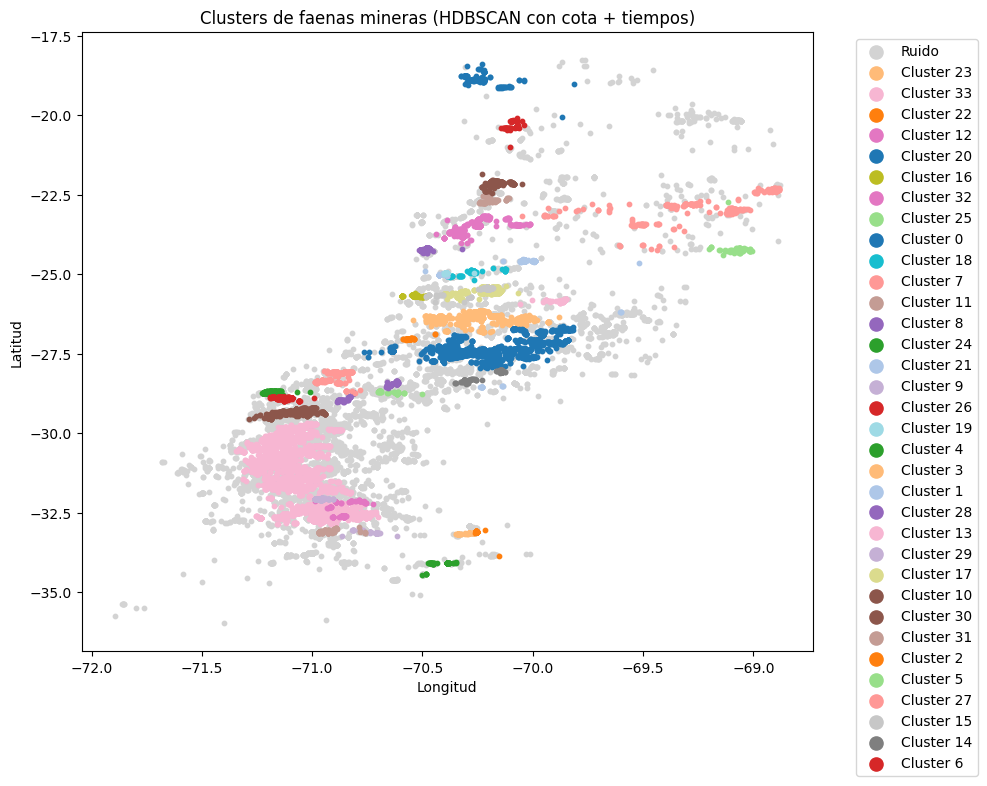

In [ ]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 1: Select variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_filtered = df[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_filtered - df_filtered.mean()) / df_filtered.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df.loc[mask].copy()

# === Step 3: Scale the features (important for HDBSCAN) ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,
    cluster_selection_epsilon=0.4,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 25 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras (HDBSCAN con cota + tiempos)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


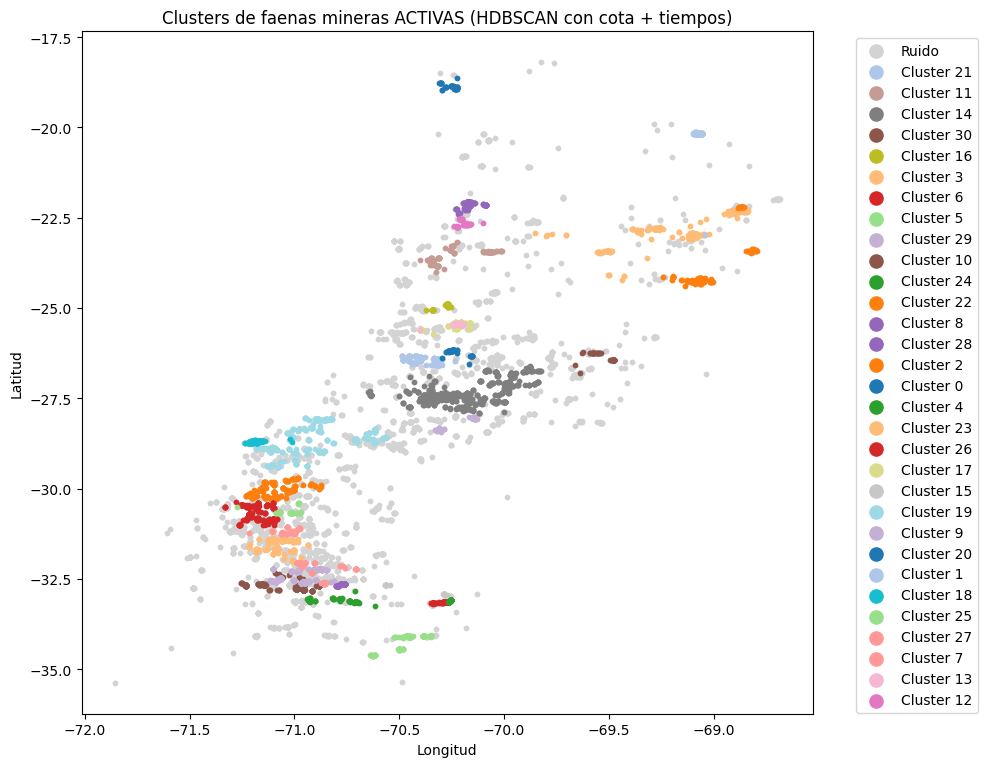

In [ ]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filter only active sites ===
df_active = df[df["Estado"] == "ACTIVA"].copy()

# === Step 1: Select relevant variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Scale features ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.35,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 40 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN con cota + tiempos)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")


C:\Users\admin\AppData\Local\Temp\ipykernel_14240\4020827223.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


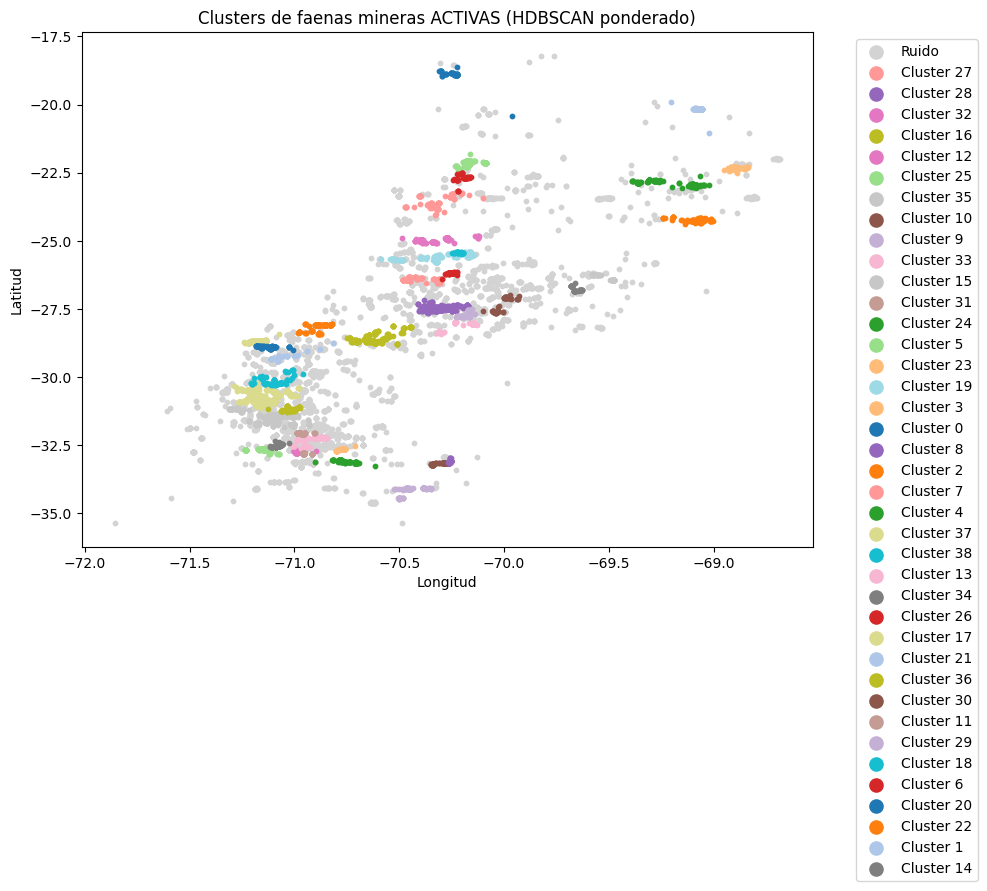

In [ ]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filter only active sites ===
df_active = df[df["Estado"] == "ACTIVA"].copy()

# === Step 1: Select relevant variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Scale and weight features ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# ⚖️ Define feature weights (tune as needed)
weights = {
    'Longitud': 3.0,          # keep high (spatial importance)
    'Latitud': 3.0,           # keep high (spatial importance)
    'Cota': 0.5,              # less important
    'Travel_min': 1.5,        # more important
    'travel_time_desal': 0.5, # moderate
    'travel_time_min': 1.0    # baseline
}

# Apply weights
for i, f in enumerate(features):
    coords_scaled[:, i] *= weights[f]

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.4,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 40 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN ponderado)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")

C:\Users\admin\AppData\Local\Temp\ipykernel_14240\4010231854.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


In [ ]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")

C:\Users\artur\AppData\Local\Temp\ipykernel_16656\4010231854.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


In [ ]:
df_faenas2 = pd.read_csv('Cluster/df_faenas_5.csv')

In [ ]:
df_faenas2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21158 entries, 0 to 21157
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RutEmpresa          21158 non-null  object 
 1   NombreEmpresa       21158 non-null  object 
 2   CategoriaFaena      21158 non-null  object 
 3   RegionInstalacion   21158 non-null  object 
 4   TipoInstalacion     21158 non-null  object 
 5   Cota                21158 non-null  int64  
 6   Huso                21158 non-null  int64  
 7   Estado              21158 non-null  object 
 8   Latitud             21158 non-null  float64
 9   Longitud            21158 non-null  float64
 10  faenas_10km         21158 non-null  int64  
 11  Cat_A_10km          21158 non-null  int64  
 12  Ciudad_Cercana      21158 non-null  object 
 13  Est_Nombre          21158 non-null  object 
 14  Est_Dist            21158 non-null  float64
 15  Est_Tiempo          21158 non-null  float64
 16  Ciud

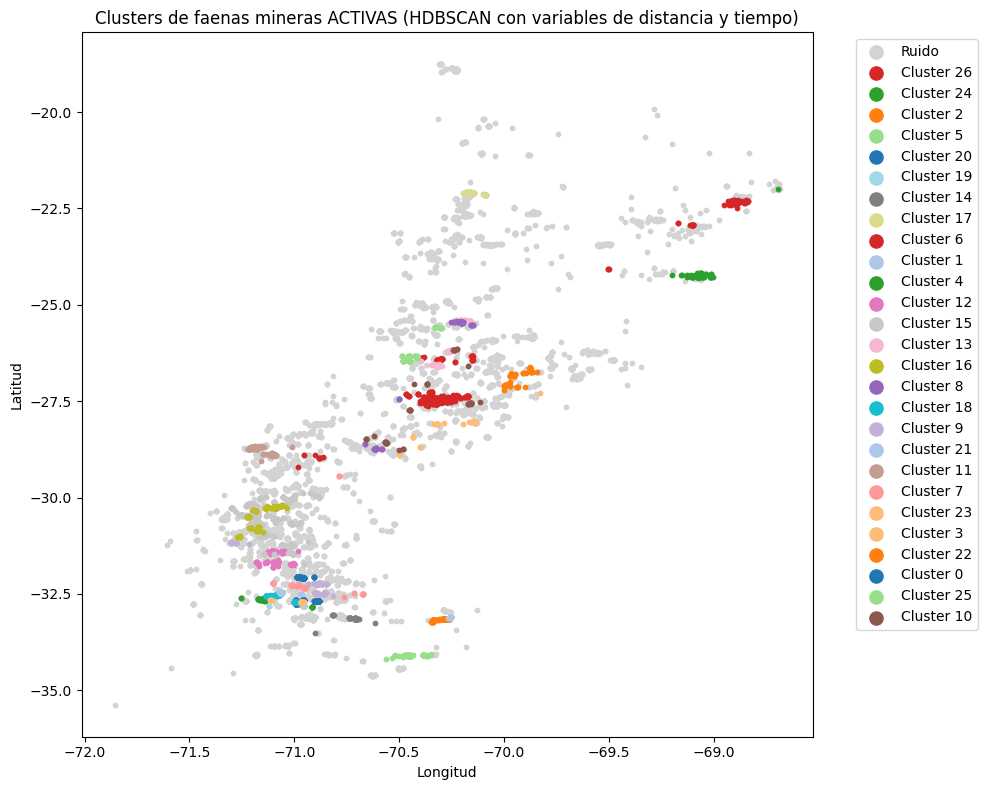

In [ ]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filtrar faenas activas ===
df_active = df_faenas2[df_faenas2["Estado"] == "ACTIVA"].copy()

# === Step 1: Seleccionar variables relevantes ===
features = [
    'Longitud', 'Latitud', 'Cota',
     'Ciudad_Tiempo',
    'Est_Dist', 'Est_Tiempo',
    'Desal_Dist_km', 
    'puerto_Tiempo',
    'lt_dist_km'
]

# Eliminar valores faltantes o infinitos
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remover outliers mediante Z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Escalar y ponderar variables ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# ⚖️ Pesos (ajustables según importancia)
weights = {
    'Longitud': 1.0,          # coordenadas espaciales
    'Latitud': 1.0,
    'Cota': 1.0,              # altura menor peso
    'Ciudad_Tiempo': 1.0,
    'Est_Dist': 1.0,          # accesibilidad ferroviaria
    'Est_Tiempo': 3.0,
    'Desal_Dist_km': 1.0,     # acceso hídrico
    'puerto_Tiempo': 1.0,
    'lt_dist_km': 3.0,        # acceso energético
}

# Aplicar pesos
for i, f in enumerate(features):
    coords_scaled[:, i] *= weights[f]

# === Step 4: Clustering con HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.45,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Mantener los 40 clusters más grandes ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Visualización ===
plt.figure(figsize=(10, 8))
cmap = plt.colormaps.get_cmap('tab20')  # ✅ nuevo estilo sin warning

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN con variables de distancia y tiempo)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
# Assuming df_clean is already defined and populated

# 1. Set the default map to 'OpenStreetMap' to show cities/regions
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='OpenStreetMap')

# 2. Add other tile layers you can switch to
folium.TileLayer(
    'Esri.WorldImagery',
    name='Satellite Imagery'
).add_to(m)

folium.TileLayer(
    'CartoDB positron',
    name='Light Map (Cities/Regions)'
).add_to(m)

# --- Your existing code for clusters ---
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % cmap.N)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    popup = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Tiempo Ciudad:</b> {row['Ciudad_Tiempo']:.1f} min<br>
    <b>Tiempo Puerto:</b> {row['puerto_Tiempo']:.1f} min<br>
    <b>Dist. Desaladora:</b> {row['Desal_Dist_km']:.1f} km
    """
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3, color=color, fill=True, fill_opacity=0.8,
        popup=folium.Popup(popup, max_width=250)
    ).add_to(m)
# --- End of your existing code ---

# 3. Add a LayerControl to the map
folium.LayerControl().add_to(m)

# Save the new map (I've updated the name slightly)
m.save('mining_clusters_with_layers.html')
print("🗺️ Mapa interactivo guardado como 'mining_clusters_with_layers.html'")

C:\Users\artur\AppData\Local\Temp\ipykernel_16656\4092962241.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🗺️ Mapa interactivo guardado como 'mining_clusters_with_layers.html'


## Con opti y mas variables

#### Librerias

In [ ]:
# Libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import logging
import joblib

# Data Processing
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN

# Clustering
import hdbscan
from hdbscan.validity import validity_index

# Optimization
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger("optuna").setLevel(logging.WARNING)

# Visualization
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from branca.element import Template, MacroElement

c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df_faenas2 = pd.read_csv('Cluster/df_faenas_5.csv')
df = df_faenas2
df = df[df['Estado'] == "ACTIVA"]

#### Base case

In [5]:
# =====================================
# CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# Target cluster range
TARGET_MIN_CLUSTERS = 20
TARGET_MAX_CLUSTERS = 40

# =====================================
# CLEAN & GROUP
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()

KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(
    eps=eps_rad,
    min_samples=1,
    metric='haversine'
)

grouped_points = []

for empresa, group in df_clean.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")

# =====================================
# SCALING
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

# =====================================
# OPTUNA OBJECTIVE
# =====================================
def objective(trial):
    # Suggest weights for each feature
    weights = {
        'Longitud':       trial.suggest_float('Longitud',       0.5, 5.0),
        'Latitud':        trial.suggest_float('Latitud',        0.5, 5.0),
        'Cota':           trial.suggest_float('Cota',           0.5, 2.0),
        'Ciudad_Tiempo':  trial.suggest_float('Ciudad_Tiempo',  0.5, 2.0),
        'Est_Tiempo':     trial.suggest_float('Est_Tiempo',     0.5, 2.0),
        'Desal_Dist_km':  trial.suggest_float('Desal_Dist_km',  0.5, 2.0),
        'puerto_Tiempo':  trial.suggest_float('puerto_Tiempo',  0.5, 2.0),
        'lt_tiempo_min':  trial.suggest_float('lt_tiempo_min',  0.5, 2.0),
    }

    # Apply weights
    X_weighted = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_weighted[:, i] *= weights[f]

    # Cluster
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=15,
        min_samples=2,
        cluster_selection_epsilon=0.15,
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_weighted)

    # Compute cluster count
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Skip if no clusters formed
    mask = labels != -1
    if mask.sum() <= 1 or n_clusters < 2:
        return -1.0

    # Compute DBCV
    try:
        dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
    except:
        return -1.0

    # Soft penalty for cluster count deviation
    target_mid = (TARGET_MIN_CLUSTERS + TARGET_MAX_CLUSTERS) / 2
    penalty = 1 - abs(n_clusters - target_mid) / target_mid
    penalty = max(penalty, 0)

    return dbcv * penalty

# =====================================
# RUN OPTIMIZATION
# =====================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# =====================================
# PRINT BEST RESULT
# =====================================
print("\n🏆 === OPTIMIZATION COMPLETE ===")
print(f"Best DBCV (penalized): {study.best_value:.4f}")
print("Best weights:")
for k, v in study.best_params.items():
    print(f"  {k:<15}: {v:.2f}")

# =====================================
# CLUSTER WITH BEST WEIGHTS
# =====================================
X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= study.best_params[f]

final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=2,
    cluster_selection_epsilon=0.15,
    metric='euclidean'
)

df_grouped['cluster'] = final_clusterer.fit_predict(X_best)

n_clusters_final = len(set(df_grouped['cluster'])) - (1 if -1 in df_grouped['cluster'].values else 0)

print(f"\n✅ Final number of clusters: {n_clusters_final}")
print(df_grouped['cluster'].value_counts())


✅ Total grouped points: 2281


Best trial: 196. Best value: 0.261603: 100%|██████████| 200/200 [01:01<00:00,  3.27it/s]


🏆 === OPTIMIZATION COMPLETE ===
Best DBCV (penalized): 0.2616
Best weights:
  Longitud       : 1.70
  Latitud        : 3.90
  Cota           : 0.74
  Ciudad_Tiempo  : 1.18
  Est_Tiempo     : 1.37
  Desal_Dist_km  : 1.87
  puerto_Tiempo  : 1.85
  lt_tiempo_min  : 0.62

✅ Final number of clusters: 31
cluster
-1     722
 17    448
 18    237
 28    104
 23     62
 20     51
 25     44
 24     44
 6      43
 27     42
 26     33
 5      31
 12     31
 16     25
 11     25
 30     25
 15     24
 3      23
 22     23
 21     23
 8      22
 9      22
 10     20
 19     20
 7      19
 0      19
 14     19
 2      18
 29     16
 1      16
 4      15
 13     15
Name: count, dtype: int64


#### Optimizacion de pesos

In [6]:
# =====================================
# CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# Target cluster range
TARGET_MIN_CLUSTERS = 20
TARGET_MAX_CLUSTERS = 40

# =====================================
# CLEAN & GROUP
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()

KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(
    eps=eps_rad,
    min_samples=1,
    metric='haversine'
)

grouped_points = []

for empresa, group in df_clean.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")

# =====================================
# SCALING
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

# =====================================
# OPTUNA OBJECTIVE
# =====================================
def objective(trial):
    # Suggest weights for each feature
    weights = {
        'Longitud':       trial.suggest_float('Longitud',       0.5, 5.0),
        'Latitud':        trial.suggest_float('Latitud',        0.5, 5.0),
        'Cota':           trial.suggest_float('Cota',           0.5, 2.0),
        'Ciudad_Tiempo':  trial.suggest_float('Ciudad_Tiempo',  0.5, 2.0),
        'Est_Tiempo':     trial.suggest_float('Est_Tiempo',     0.5, 2.0),
        'Desal_Dist_km':  trial.suggest_float('Desal_Dist_km',  0.5, 2.0),
        'puerto_Tiempo':  trial.suggest_float('puerto_Tiempo',  0.5, 2.0),
        'lt_tiempo_min':  trial.suggest_float('lt_tiempo_min',  0.5, 2.0),
    }

    # Apply weights
    X_weighted = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_weighted[:, i] *= weights[f]

    # Cluster
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=15,
        min_samples=2,
        cluster_selection_epsilon=0.15,
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_weighted)

    # Compute cluster count
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Skip if no clusters formed
    mask = labels != -1
    if mask.sum() <= 1 or n_clusters < 2:
        return -1.0

    # Compute DBCV
    try:
        dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
    except:
        return -1.0

    # Soft penalty for cluster count deviation
    target_mid = (TARGET_MIN_CLUSTERS + TARGET_MAX_CLUSTERS) / 2
    penalty = 1 - abs(n_clusters - target_mid) / target_mid
    penalty = max(penalty, 0)

    return dbcv * penalty

# =====================================
# RUN OPTIMIZATION
# =====================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# =====================================
# PRINT BEST RESULT
# =====================================
print("\n🏆 === OPTIMIZATION COMPLETE ===")
print(f"Best DBCV (penalized): {study.best_value:.4f}")
print("Best weights:")
for k, v in study.best_params.items():
    print(f"  {k:<15}: {v:.2f}")

# =====================================
# CLUSTER WITH BEST WEIGHTS
# =====================================
X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= study.best_params[f]

final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=2,
    cluster_selection_epsilon=0.15,
    metric='euclidean'
)

df_grouped['cluster'] = final_clusterer.fit_predict(X_best)

n_clusters_final = len(set(df_grouped['cluster'])) - (1 if -1 in df_grouped['cluster'].values else 0)

print(f"\n✅ Final number of clusters: {n_clusters_final}")
print(df_grouped['cluster'].value_counts())



✅ Total grouped points: 2281


Best trial: 81. Best value: 0.25616: 100%|██████████| 200/200 [01:01<00:00,  3.26it/s]


🏆 === OPTIMIZATION COMPLETE ===
Best DBCV (penalized): 0.2562
Best weights:
  Longitud       : 4.70
  Latitud        : 4.78
  Cota           : 1.08
  Ciudad_Tiempo  : 0.64
  Est_Tiempo     : 1.04
  Desal_Dist_km  : 1.95
  puerto_Tiempo  : 1.89
  lt_tiempo_min  : 1.68

✅ Final number of clusters: 30
cluster
-1     716
 17    387
 18    231
 26    119
 23     63
 25     56
 24     52
 21     48
 20     48
 29     43
 3      42
 19     42
 4      40
 11     31
 28     30
 12     28
 7      26
 9      26
 27     25
 8      24
 22     23
 5      23
 6      21
 1      19
 10     18
 0      18
 16     18
 13     17
 15     16
 14     16
 2      15
Name: count, dtype: int64


In [7]:
# =====================================
# VISUALIZATION ON CHILE MAP
# =====================================
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# Center of Chile
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# Define colormap
num_clusters = len(df_grouped['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i)[:3]) for i, c in enumerate(sorted(df_grouped['cluster'].unique()))}

# Add points to map
for _, row in df_grouped.iterrows():
    cluster_id = row['cluster']
    color = '#999999' if cluster_id == -1 else color_dict[cluster_id]
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"Empresa: {row['NombreEmpresa']}<br>Cluster: {cluster_id}", max_width=300)
    ).add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed; bottom: 30px; left: 30px; width: 250px; height: 180px;
             border:2px solid grey; z-index:9999; font-size:14px; background:white; overflow-y:auto;">
  &nbsp;<b>Cluster Legend</b><br>
  {}
</div>
'''.format("<br>".join([
    f"&nbsp;<i style='background:{color_dict[c]};width:12px;height:12px;display:inline-block;'></i>&nbsp;Cluster {c}"
    for c in sorted(df_grouped['cluster'].unique()) if c != -1
]))
m.get_root().html.add_child(folium.Element(legend_html))

# Save to HTML
m.save("clusters_chile.html")
print("🌎 Map saved as clusters_chile.html — open it in your browser.")


C:\Users\admin\AppData\Local\Temp\ipykernel_10092\983453453.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🌎 Map saved as clusters_chile.html — open it in your browser.


#### Con optimizacion de hdbscan

In [8]:
# =====================================
# CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# Target cluster range
TARGET_MIN_CLUSTERS = 20
TARGET_MAX_CLUSTERS = 40

# =====================================
# CLEAN & GROUP
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()

KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(
    eps=eps_rad,
    min_samples=1,
    metric='haversine'
)

grouped_points = []

for empresa, group in df_clean.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")

# =====================================
# SCALING
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

# =====================================
# OPTUNA OBJECTIVE
# =====================================
def objective(trial):
    # Suggest weights for each feature
    weights = {
        'Longitud':       trial.suggest_float('Longitud',       0.5, 5.0),
        'Latitud':        trial.suggest_float('Latitud',        0.5, 5.0),
        'Cota':           trial.suggest_float('Cota',           0.5, 2.0),
        'Ciudad_Tiempo':  trial.suggest_float('Ciudad_Tiempo',  0.5, 2.0),
        'Est_Tiempo':     trial.suggest_float('Est_Tiempo',     0.5, 2.0),
        'Desal_Dist_km':  trial.suggest_float('Desal_Dist_km',  0.5, 2.0),
        'puerto_Tiempo':  trial.suggest_float('puerto_Tiempo',  0.5, 2.0),
        'lt_tiempo_min':  trial.suggest_float('lt_tiempo_min',  0.5, 2.0),
    }

    # Apply weights
    X_weighted = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_weighted[:, i] *= weights[f]

    # Cluster
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=15,
        min_samples=2,
        cluster_selection_epsilon=0.15,
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_weighted)

    # Compute cluster count
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Skip if no clusters formed
    mask = labels != -1
    if mask.sum() <= 1 or n_clusters < 2:
        return -1.0

    # Compute DBCV
    try:
        dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
    except:
        return -1.0

    # Soft penalty for cluster count deviation
    target_mid = (TARGET_MIN_CLUSTERS + TARGET_MAX_CLUSTERS) / 2
    penalty = 1 - abs(n_clusters - target_mid) / target_mid
    penalty = max(penalty, 0)

    return dbcv * penalty

# =====================================
# RUN OPTIMIZATION
# =====================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# =====================================
# PRINT BEST RESULT
# =====================================
print("\n🏆 === OPTIMIZATION COMPLETE ===")
print(f"Best DBCV (penalized): {study.best_value:.4f}")
print("Best weights:")
for k, v in study.best_params.items():
    print(f"  {k:<15}: {v:.2f}")

# =====================================
# CLUSTER WITH BEST WEIGHTS
# =====================================
X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= study.best_params[f]

final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=2,
    cluster_selection_epsilon=0.15,
    metric='euclidean'
)

df_grouped['cluster'] = final_clusterer.fit_predict(X_best)

n_clusters_final = len(set(df_grouped['cluster'])) - (1 if -1 in df_grouped['cluster'].values else 0)

print(f"\n✅ Final number of clusters: {n_clusters_final}")
print(df_grouped['cluster'].value_counts())



✅ Total grouped points: 2281


Best trial: 145. Best value: 0.257489: 100%|██████████| 200/200 [00:58<00:00,  3.42it/s]


🏆 === OPTIMIZATION COMPLETE ===
Best DBCV (penalized): 0.2575
Best weights:
  Longitud       : 1.81
  Latitud        : 3.87
  Cota           : 0.62
  Ciudad_Tiempo  : 0.55
  Est_Tiempo     : 0.84
  Desal_Dist_km  : 1.69
  puerto_Tiempo  : 1.54
  lt_tiempo_min  : 0.86

✅ Final number of clusters: 31
cluster
-1     694
 17    440
 16    234
 30    107
 24     63
 10     56
 29     53
 25     46
 28     44
 3      44
 23     40
 4      32
 26     30
 7      29
 22     29
 14     26
 20     26
 12     25
 21     24
 5      22
 0      21
 15     21
 11     21
 13     20
 1      19
 9      19
 19     18
 6      17
 2      16
 27     15
 18     15
 8      15
Name: count, dtype: int64


In [9]:
# =====================================
# Setup base map (Chile)
# =====================================
m = folium.Map(
    location=[-27, -70],
    zoom_start=4.5,
    tiles=None
)

# Satellite and light map layers
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri World Imagery",
    name="🌍 Satellite"
).add_to(m)

folium.TileLayer(
    "CartoDB positron",
    name="🗺️ Light Map"
).add_to(m)

# =====================================
# Color setup
# =====================================
num_clusters = len(df_grouped['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {
    c: colors.rgb2hex(cmap(i % cmap.N)) for i, c in enumerate(sorted(df_grouped['cluster'].unique()))
}

# =====================================
# Add points
# =====================================
for _, row in df_grouped.iterrows():
    cluster = row['cluster']
    color = "#808080" if cluster == -1 else color_dict[cluster]

    popup_text = f"""
    <b>Empresa:</b> {row.get('NombreEmpresa', 'N/A')}<br>
    <b>Cluster:</b> {cluster}<br>
    <b>Faenas:</b> {row.get('FaenasCount', 'N/A')}
    """
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# =====================================
# Layer control + Save
# =====================================
folium.LayerControl().add_to(m)

# Save to HTML file
output_path = "chile_clusters_map.html"
m.save(output_path)

print(f"✅ Map saved as {output_path}. Open it in your browser!")


C:\Users\admin\AppData\Local\Temp\ipykernel_10092\2405843681.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Map saved as chile_clusters_map.html. Open it in your browser!


In [10]:
# =====================================
# CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

WEIGHT_RANGE = (0.2, 5.0)
TARGET_MIN_CLUSTERS = 30
TARGET_MAX_CLUSTERS = 60
RANDOM_STATE = 42  # reproducible

# =====================================
# DATA PREP
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_clean[clustering_features])

# =====================================
# OBJECTIVE FUNCTION
# =====================================
def objective(trial):
    np.random.seed(RANDOM_STATE)
    
    # --- Weights ---
    weights = {}
    for f in clustering_features:
        if f in ["Latitud", "Longitud"]:
            weights[f] = trial.suggest_float(f"w_{f}", 2.0, 5.0)
        else:
            weights[f] = trial.suggest_float(f"w_{f}", WEIGHT_RANGE[0], WEIGHT_RANGE[1])
    
    # --- HDBSCAN parameters (wider ranges) ---
    min_cluster_size = trial.suggest_int("min_cluster_size", 2, 15)  # smaller min size to allow more clusters
    min_samples = trial.suggest_int("min_samples", 1, 10)
    epsilon = trial.suggest_float("cluster_selection_epsilon", 0.0, 1.0)  # wider range
    
    # --- Apply weights ---
    X_weighted = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_weighted[:, i] *= weights[f]
    
    # --- HDBSCAN clustering ---
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=epsilon,
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_weighted)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # --- Calculate DBCV ---
    try:
        dbcv = validity_index(X_weighted, labels, metric='euclidean')
    except Exception:
        dbcv = -1.0
    
    # --- Soft penalty for cluster count ---
    target_mid = (TARGET_MIN_CLUSTERS + TARGET_MAX_CLUSTERS) / 2
    penalty = 1 - abs(n_clusters - target_mid) / target_mid
    penalty = max(penalty, 0)  # ensure non-negative
    
    score = dbcv * penalty
    
    # --- Store extra info ---
    trial.set_user_attr("n_clusters", n_clusters)
    trial.set_user_attr("weights", weights)
    
    return score

# =====================================
# OPTUNA OPTIMIZATION
# =====================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, show_progress_bar=False)

# =====================================
# TOP 5 TRIALS
# =====================================
print("\n === TOP 5 TRIALS BY SCORE ===")
sorted_trials = sorted(study.trials, key=lambda t: t.value if t.value is not None else -1, reverse=True)[:5]

results = []
for i, trial in enumerate(sorted_trials, start=1):
    val = trial.value
    n_clusters = trial.user_attrs.get("n_clusters", None)
    weights = trial.user_attrs.get("weights", {})
    print(f"\n🔹 Rank {i}")
    print(f"   Trial #{trial.number}")
    print(f"   Score: {val:.4f}")
    print(f"   Clusters: {n_clusters}")
    for k, v in weights.items():
        print(f"     {k}: {v:.3f}")
    results.append({
        "Rank": i,
        "Trial": trial.number,
        "Score": val,
        "Clusters": n_clusters,
        **weights
    })

df_results = pd.DataFrame(results)
print("\n=== SUMMARY TABLE ===")
print(df_results)

# =====================================
# FINAL BEST MODEL
# =====================================
best_trial = study.best_trial
best_weights = {f: best_trial.params[f"w_{f}"] for f in clustering_features}

X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= best_weights[f]

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best_trial.params["min_cluster_size"],
    min_samples=best_trial.params["min_samples"],
    cluster_selection_epsilon=best_trial.params["cluster_selection_epsilon"],
    metric='euclidean'
)
final_labels = clusterer.fit_predict(X_best)
df_clean["cluster"] = final_labels

print(f"\n✅ Final model: {len(set(final_labels)) - (1 if -1 in final_labels else 0)} clusters.")




 === TOP 5 TRIALS BY SCORE ===

🔹 Rank 1
   Trial #0
   Score: 0.0000
   Clusters: 260
     Longitud: 4.712
     Latitud: 4.961
     Cota: 4.814
     Ciudad_Tiempo: 1.245
     Est_Tiempo: 0.301
     Desal_Dist_km: 1.117
     puerto_Tiempo: 2.187
     lt_tiempo_min: 1.062

🔹 Rank 2
   Trial #1
   Score: 0.0000
   Clusters: 227
     Longitud: 2.664
     Latitud: 4.446
     Cota: 1.504
     Ciudad_Tiempo: 0.234
     Est_Tiempo: 1.724
     Desal_Dist_km: 3.470
     puerto_Tiempo: 3.967
     lt_tiempo_min: 0.347

🔹 Rank 3
   Trial #2
   Score: 0.0000
   Clusters: 382
     Longitud: 3.699
     Latitud: 2.966
     Cota: 2.430
     Ciudad_Tiempo: 3.053
     Est_Tiempo: 4.743
     Desal_Dist_km: 3.791
     puerto_Tiempo: 4.282
     lt_tiempo_min: 0.203

🔹 Rank 4
   Trial #3
   Score: 0.0000
   Clusters: 199
     Longitud: 2.410
     Latitud: 2.080
     Cota: 4.231
     Ciudad_Tiempo: 2.475
     Est_Tiempo: 0.590
     Desal_Dist_km: 4.910
     puerto_Tiempo: 1.056
     lt_tiempo_min: 2.017

🔹 R

In [11]:
# =====================================
# MAP VISUALIZATION
# =====================================
num_clusters = df_grouped['cluster'].nunique()
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i % 20)[:3]) for i, c in enumerate(sorted(df_grouped['cluster'].unique()))}

m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

for _, row in df_grouped.iterrows():
    if row['cluster'] == -1:
        continue
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color_dict[row['cluster']],
        fill=True,
        fill_opacity=0.8,
        popup=f"Empresa: {row['NombreEmpresa']}<br>Cluster: {row['cluster']}"
    ).add_to(m)

output_file = "clusters_chile.html"
m.save(output_file)
print(f"\n🌎 Map saved as {output_file}")


C:\Users\admin\AppData\Local\Temp\ipykernel_10092\4084642122.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)



🌎 Map saved as clusters_chile.html


### Separacion del pais

In [12]:
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

TARGET_MIN_CLUSTERS = 20
TARGET_MAX_CLUSTERS = 40

# =====================================
# CLEAN & GROUP
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()

KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_clean.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")

# =====================================
# SCALING
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

# =====================================
# OPTUNA OBJECTIVE
# =====================================
def objective(trial):
    weights = {
        'Longitud': trial.suggest_float('Longitud', 0.5, 5.0),
        'Latitud': trial.suggest_float('Latitud', 0.5, 5.0),
        'Cota': trial.suggest_float('Cota', 0.5, 2.0),
        'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 2.0),
        'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.0),
        'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 2.0),
        'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 2.0),
        'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.0),
    }

    min_cluster_size = trial.suggest_int('min_cluster_size', 5, 50)
    min_samples = trial.suggest_int('min_samples', 1, 15)
    epsilon = trial.suggest_float('cluster_selection_epsilon', 0.0, 0.5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])

    X_weighted = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_weighted[:, i] *= weights[f]

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=epsilon,
        metric=metric
    )
    labels = clusterer.fit_predict(X_weighted)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    mask = labels != -1
    if mask.sum() <= 1 or n_clusters < 2:
        return -1.0

    try:
        dbcv = validity_index(X_weighted[mask], labels[mask], metric=metric)
    except Exception:
        return -1.0

    target_mid = (TARGET_MIN_CLUSTERS + TARGET_MAX_CLUSTERS) / 2
    penalty = 1 - abs(n_clusters - target_mid) / target_mid
    penalty = max(penalty, 0)

    return dbcv * penalty

# =====================================
# RUN OPTIMIZATION
# =====================================
def optimize_study(n_trials=150):
    study = optuna.create_study(direction="maximize")
    for _ in tqdm(range(n_trials), desc="Optimizing", ncols=80):
        study.optimize(objective, n_trials=1, show_progress_bar=False, catch=(Exception,))
    return study

study = optimize_study(n_trials=150)

# =====================================
# PRINT BEST RESULT
# =====================================
print("\n🏆 === OPTIMIZATION COMPLETE ===")
print(f"Best penalized DBCV: {study.best_value:.4f}")

print("\n🧩 === Best Parameters ===")
print(f"min_cluster_size: {study.best_params['min_cluster_size']}")
print(f"min_samples: {study.best_params['min_samples']}")
print(f"epsilon: {study.best_params['cluster_selection_epsilon']:.3f}")
print(f"metric: {study.best_params['metric']}")
print("\n⚖️ === Ideal Weights ===")
for f in clustering_features:
    print(f"  {f}: {study.best_params[f]:.2f}")

# =====================================
# CLUSTER WITH BEST CONFIG
# =====================================
X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= study.best_params[f]

final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=study.best_params['min_cluster_size'],
    min_samples=study.best_params['min_samples'],
    cluster_selection_epsilon=study.best_params['cluster_selection_epsilon'],
    metric=study.best_params['metric']
)
df_grouped['cluster'] = final_clusterer.fit_predict(X_best)

n_clusters_final = len(set(df_grouped['cluster'])) - (1 if -1 in df_grouped['cluster'].values else 0)
dbcv_final = validity_index(X_best[df_grouped['cluster'] != -1], df_grouped.loc[df_grouped['cluster'] != -1, 'cluster'], metric=study.best_params['metric'])

print(f"\n✅ Final number of clusters: {n_clusters_final}")
print(f"📈 Final DBCV (no penalty): {dbcv_final:.4f}")

# Save model
joblib.dump(final_clusterer, "hdbscan_best_model.pkl")

# Optional: show cluster size distribution
print("\n📊 Cluster size distribution:")
print(df_grouped['cluster'].value_counts().sort_index())


✅ Total grouped points: 2281


Optimizing: 100%|█████████████████████████████| 150/150 [00:56<00:00,  2.66it/s]



🏆 === OPTIMIZATION COMPLETE ===
Best penalized DBCV: 0.4174

🧩 === Best Parameters ===
min_cluster_size: 6
min_samples: 10
epsilon: 0.198
metric: euclidean

⚖️ === Ideal Weights ===
  Longitud: 1.10
  Latitud: 0.90
  Cota: 0.73
  Ciudad_Tiempo: 1.66
  Est_Tiempo: 1.67
  Desal_Dist_km: 1.07
  puerto_Tiempo: 1.17
  lt_tiempo_min: 0.86

✅ Final number of clusters: 30
📈 Final DBCV (no penalty): 0.4174

📊 Cluster size distribution:
cluster
-1     1480
 0       13
 1        7
 2       14
 3       14
 4       11
 5       11
 6       31
 7       15
 8       15
 9       24
 10      18
 11      17
 12     220
 13      12
 14      37
 15       7
 16       9
 17      24
 18      47
 19      12
 20      14
 21       9
 22      36
 23       6
 24      13
 25       9
 26      13
 27     105
 28      10
 29      28
Name: count, dtype: int64


In [ ]:
# =====================================
# MAPA INTERACTIVO
# =====================================
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

print("\n Generando mapa")

# Base map centered over Chile
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# Compute cluster colors
num_clusters = df_grouped['cluster'].nunique()
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {
    c: colors.rgb2hex(cmap(i)[:3])
    for i, c in enumerate(sorted(df_grouped['cluster'].unique()))
}

# Add points to map
for _, row in df_grouped.iterrows():
    cluster_id = row['cluster']
    color = '#999999' if cluster_id == -1 else color_dict[cluster_id]
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.75,
        popup=folium.Popup(
            f"<b>Empresa:</b> {row['NombreEmpresa']}<br>"
            f"<b>Cluster:</b> {cluster_id}<br>"
            f"<b>Faenas agrupadas:</b> {int(row['FaenasCount'])}",
            max_width=300
        )
    ).add_to(m)

# =====================================
# LEGEND
# =====================================
legend_entries = [
    f"&nbsp;<i style='background:{color_dict[c]};width:12px;height:12px;"
    f"display:inline-block;margin-right:6px;'></i>Cluster {c}"
    for c in sorted(df_grouped['cluster'].unique()) if c != -1
]
legend_html = f"""
<div style="
    position: fixed; bottom: 30px; left: 30px; width: 260px; max-height: 200px;
    border:2px solid grey; z-index:9999; font-size:13px;
    background:white; padding:10px; overflow-y:auto; border-radius:8px;">
    <b>Cluster Legend</b><br>{'<br>'.join(legend_entries)}
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# =====================================
# SAVE MAP
# =====================================
m.save("clusters_chile_optimized.html")
print("🌎 Mapa guardado como clusters_chile_optimized.html")



🗺️ Generando mapa interactivo...


C:\Users\admin\AppData\Local\Temp\ipykernel_10092\1533429464.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🌎 Mapa guardado como clusters_chile_optimized.html


#### Coquimbo y valpo

In [15]:
# =====================================
# FIX REGION MISLABELS USING LATITUDE
# =====================================

# Normalize region names
df['RegionInstalacion'] = df['RegionInstalacion'].str.upper().str.strip()

# Identify Metropolitana points that are actually north (i.e., Valparaíso zone)
mask_wrong_north = (df['RegionInstalacion'] == 'METROPOLITANA DE SANTIAGO') & (df['Latitud'] > -33)

# Reassign them
df.loc[mask_wrong_north, 'RegionInstalacion'] = 'VALPARAISO'

print(f"🔧 Corrected {mask_wrong_north.sum()} northern Metropolitana points → Valparaíso based on latitude.")


🔧 Corrected 20 northern Metropolitana points → Valparaíso based on latitude.


C:\Users\admin\AppData\Local\Temp\ipykernel_10092\524199408.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RegionInstalacion'] = df['RegionInstalacion'].str.upper().str.strip()


In [16]:
# =====================================
# COQUIMBO + VALPARAÍSO VS RESTO DE CHILE
# SPLIT REGIONS
# =====================================
coqvalpo_regiones = ['COQUIMBO', 'VALPARAISO']
coqvalpo_df = df[df['RegionInstalacion'].isin(coqvalpo_regiones)].copy()
rest_df = df[~df['RegionInstalacion'].isin(coqvalpo_regiones)].copy()

print(f"📍 Puntos Coquimbo+Valparaíso: {len(coqvalpo_df)}, resto del país: {len(rest_df)}")

# =====================================
# FEATURES
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'lt_tiempo_min', 'puerto_Tiempo'
]

# =====================================
# GROUP BY EMPRESA
# =====================================
def group_by_empresa(df_region):
    KM_RADIUS = 1.65
    EARTH_RADIUS_KM = 6371
    eps_rad = KM_RADIUS / EARTH_RADIUS_KM

    dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')
    grouped_points = []

    for empresa, group in df_region.groupby("NombreEmpresa"):
        coords_rad = np.radians(group[['Latitud', 'Longitud']])
        sub_labels = dbscan_grouper.fit_predict(coords_rad)
        group = group.assign(sub_cluster=sub_labels)  # avoid chained assignment

        for label, subset in group.groupby('sub_cluster'):
            row = subset.mean(numeric_only=True).to_dict()
            row["NombreEmpresa"] = empresa
            row["FaenasCount"] = len(subset)
            grouped_points.append(row)

    return pd.DataFrame(grouped_points)

coqvalpo_grouped = group_by_empresa(coqvalpo_df)
rest_grouped = group_by_empresa(rest_df)

# =====================================
# SCALING
# =====================================
scaler_coq = RobustScaler()
X_coq_scaled = scaler_coq.fit_transform(coqvalpo_grouped[clustering_features])

scaler_rest = RobustScaler()
X_rest_scaled = scaler_rest.fit_transform(rest_grouped[clustering_features])

# =====================================
# OBJECTIVE FACTORY
# =====================================
def make_objective(X_scaled, features, target_min, target_max,
                   min_cluster_size_range, min_samples_range):
    """Creates an Optuna objective function for HDBSCAN optimization."""
    def objective(trial):
        weights = {
            'Longitud': trial.suggest_float('Longitud', 2.0, 5.0),
            'Latitud': trial.suggest_float('Latitud', 2.0, 5.0),
            'Cota': trial.suggest_float('Cota', 0.5, 2.0),
            'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 2.0),
            'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.0),
            'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 2.0),
            'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 2.0),
            'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.0),
        }

        # Apply feature weights
        X_weighted = X_scaled.copy()
        for i, f in enumerate(features):
            X_weighted[:, i] *= weights[f]

        # Hyperparameters
        min_cluster_size = trial.suggest_int("min_cluster_size", *min_cluster_size_range)
        min_samples = trial.suggest_int("min_samples", *min_samples_range)
        epsilon = trial.suggest_float("cluster_selection_epsilon", 0.05, 0.4)

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            metric='euclidean'
        )

        labels = clusterer.fit_predict(X_weighted)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        mask = labels != -1
        if mask.sum() <= 1 or n_clusters < 2:
            return -1.0

        try:
            dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
        except Exception:
            return -1.0

        # Penalize based on deviation from target cluster count
        target_mid = (target_min + target_max) / 2
        penalty = 1 - abs(n_clusters - target_mid) / target_mid
        penalty = max(penalty, 0)

        return dbcv * penalty

    return objective

# =====================================
# OPTIMIZATION FUNCTION
# =====================================
def optimize_region(X_scaled, features, region_name,
                    target_range, min_cluster_size_range, min_samples_range,
                    n_trials=100):
    print(f"\n🔍 Optimizing {region_name} | Target clusters {target_range} | "
          f"min_cluster_size {min_cluster_size_range} | min_samples {min_samples_range}")
    study = optuna.create_study(direction="maximize")
    study.optimize(
        make_objective(X_scaled, features, *target_range,
                       min_cluster_size_range, min_samples_range),
        n_trials=n_trials,
        show_progress_bar=True
    )
    return study

# =====================================
# RUN OPTIMIZATION
# =====================================
coqvalpo_study = optimize_region(
    X_coq_scaled, clustering_features, "Coquimbo+Valparaíso",
    target_range=(3, 6),
    min_cluster_size_range=(15, 25),
    min_samples_range=(3, 6),
    n_trials=400
)

rest_study = optimize_region(
    X_rest_scaled, clustering_features, "Resto de Chile",
    target_range=(15, 25),
    min_cluster_size_range=(30, 40),
    min_samples_range=(1, 3),
    n_trials=600
)

# =====================================
# APPLY BEST MODEL
# =====================================
def cluster_best(X_scaled, study, features, name="region"):
    X_best = X_scaled.copy()
    for i, f in enumerate(features):
        X_best[:, i] *= study.best_params[f]

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=study.best_params["min_cluster_size"],
        min_samples=study.best_params["min_samples"],
        cluster_selection_epsilon=study.best_params["cluster_selection_epsilon"],
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_best)

    mask = labels != -1
    dbcv_score = (validity_index(X_best[mask], labels[mask], metric='euclidean')
                  if mask.sum() > 1 and len(set(labels[mask])) > 1 else -1.0)

    joblib.dump(clusterer, f"hdbscan_{name}_best_model.pkl")

    print(f"\n✅ {name.upper()} model saved: hdbscan_{name}_best_model.pkl")
    print(f"🏅 {name.upper()} DBCV score: {dbcv_score:.4f}")
    print(f"📦 {name.upper()} clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

    return labels, dbcv_score

coqvalpo_grouped['cluster'], dbcv_coqvalpo = cluster_best(X_coq_scaled, coqvalpo_study, clustering_features, "coq_valpo")
rest_grouped['cluster'], dbcv_rest = cluster_best(X_rest_scaled, rest_study, clustering_features, "rest")

# =====================================
# COMBINE RESULTS
# =====================================
df_final = pd.concat([coqvalpo_grouped, rest_grouped], ignore_index=True)
print("\n📊 SUMMARY")
print(f"• Coquimbo+Valparaíso DBCV: {dbcv_coqvalpo:.4f}")
print(f"• Resto de Chile DBCV: {dbcv_rest:.4f}")
print(f"✅ Total clusters combinados: {df_final['cluster'].nunique()}")

📍 Puntos Coquimbo+Valparaíso: 3246, resto del país: 4671

🔍 Optimizing Coquimbo+Valparaíso | Target clusters (3, 6) | min_cluster_size (15, 25) | min_samples (3, 6)


Best trial: 251. Best value: 0.226378: 100%|██████████| 400/400 [00:43<00:00,  9.12it/s]



🔍 Optimizing Resto de Chile | Target clusters (15, 25) | min_cluster_size (30, 40) | min_samples (1, 3)


Best trial: 329. Best value: 0.255281: 100%|██████████| 600/600 [02:03<00:00,  4.87it/s]


✅ COQ_VALPO model saved: hdbscan_coq_valpo_best_model.pkl
🏅 COQ_VALPO DBCV score: 0.3396
📦 COQ_VALPO clusters: 3

✅ REST model saved: hdbscan_rest_best_model.pkl
🏅 REST DBCV score: 0.3927
📦 REST clusters: 13

📊 SUMMARY
• Coquimbo+Valparaíso DBCV: 0.3396
• Resto de Chile DBCV: 0.3927
✅ Total clusters combinados: 14


In [17]:
# =====================================
# MAP VISUALIZATION
# =====================================
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')
num_clusters = df_final['cluster'].nunique()

cmap = cm.get_cmap('tab20', num_clusters) if hasattr(cm, 'get_cmap') else \
       colors.Colormap('tab20')
color_dict = {c: colors.rgb2hex(cmap(i)[:3]) for i, c in enumerate(sorted(df_final['cluster'].unique()))}

for _, row in df_final.iterrows():
    cluster_id = row['cluster']
    color = '#999999' if cluster_id == -1 else color_dict[cluster_id]
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"<b>Empresa:</b> {row['NombreEmpresa']}<br><b>Cluster:</b> {cluster_id}", max_width=300)
    ).add_to(m)

m.save("clusters_chile_flexible_ranges.html")
print("🌎 Mapa guardado como clusters_chile_flexible_ranges.html")

C:\Users\admin\AppData\Local\Temp\ipykernel_10092\3570071905.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters) if hasattr(cm, 'get_cmap') else \


🌎 Mapa guardado como clusters_chile_flexible_ranges.html


#### NORTE / ATACAMA / COQUIMBO / SUR

In [18]:
# =====================================
# SPLIT REGIONAL: NORTE / ATACAMA / COQUIMBO / SUR
# =====================================

df['RegionInstalacion'] = df['RegionInstalacion'].str.upper().str.strip()

norte_regiones = ['ANTOFAGASTA', 'ARICA Y PARINACOTA', 'TARAPACA']
atacama_regiones = ['ATACAMA']
coquimbo_regiones = ['COQUIMBO']
sur_regiones = [
    'VALPARAISO',
    'METROPOLITANA DE SANTIAGO',
    'LIBERTADOR GENERAL BERNARDO OHIGGINS',
    'MAULE'
]

mask_norte = df['RegionInstalacion'].isin(norte_regiones)
mask_atacama = df['RegionInstalacion'].isin(atacama_regiones)
mask_coquimbo = df['RegionInstalacion'].isin(coquimbo_regiones)
mask_sur = df['RegionInstalacion'].isin(sur_regiones)

df_norte = df[mask_norte].copy()
df_atacama = df[mask_atacama].copy()
df_coquimbo = df[mask_coquimbo].copy()
df_sur = df[mask_sur].copy()

# =====================================
# FEATURES
# =====================================

clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'lt_tiempo_min', 'puerto_Tiempo'
]


# =====================================
# GROUP BY EMPRESA (DBSCAN haversine)
# =====================================

def group_by_empresa(df_region):
    KM_RADIUS = 1.75
    EARTH_RADIUS_KM = 6371
    eps_rad = KM_RADIUS / EARTH_RADIUS_KM

    dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')
    grouped_points = []

    for empresa, group in df_region.groupby("NombreEmpresa"):
        coords_rad = np.radians(group[['Latitud', 'Longitud']])
        sub_labels = dbscan_grouper.fit_predict(coords_rad)
        group['sub_cluster'] = sub_labels

        for label, subset in group.groupby('sub_cluster'):
            row = subset.mean(numeric_only=True).to_dict()
            row["NombreEmpresa"] = empresa
            row["FaenasCount"] = len(subset)
            grouped_points.append(row)

    return pd.DataFrame(grouped_points)


norte_grouped = group_by_empresa(df_norte)
atacama_grouped = group_by_empresa(df_atacama)
coquimbo_grouped = group_by_empresa(df_coquimbo)
sur_grouped = group_by_empresa(df_sur)


# =====================================
# SCALING
# =====================================

scaler = RobustScaler()

X_norte_scaled = scaler.fit_transform(norte_grouped[clustering_features])
X_atacama_scaled = scaler.fit_transform(atacama_grouped[clustering_features])
X_coquimbo_scaled = scaler.fit_transform(coquimbo_grouped[clustering_features])
X_sur_scaled = scaler.fit_transform(sur_grouped[clustering_features])


# =====================================
# OBJECTIVE (Optuna)
# =====================================

def make_objective(X_scaled, clustering_features, target_min, target_max,
                   min_cluster_size_range, min_samples_range):
    def objective(trial):
        weights = {
            'Longitud': trial.suggest_float('Longitud', 2.0, 5.5),
            'Latitud': trial.suggest_float('Latitud', 2.0, 5.5),
            'Cota': trial.suggest_float('Cota', 0.5, 2.5),
            'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 3.0),
            'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.5),
            'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 3.0),
            'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 3.0),
            'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.5),
        }

        X_weighted = X_scaled.copy()
        for i, f in enumerate(clustering_features):
            X_weighted[:, i] *= weights.get(f, 1.0)

        min_cluster_size = trial.suggest_int("min_cluster_size",
                                             *min_cluster_size_range)
        min_samples = trial.suggest_int("min_samples", *min_samples_range)
        epsilon = trial.suggest_float("cluster_selection_epsilon", 0.05, 0.4)

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            metric='euclidean'
        )
        labels = clusterer.fit_predict(X_weighted)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        mask = labels != -1
        if mask.sum() <= 1 or n_clusters < 2:
            return -1.0

        try:
            dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
        except Exception:
            return -1.0

        target_mid = (target_min + target_max) / 2
        penalty = 1 - abs(n_clusters - target_mid) / target_mid
        return dbcv * max(penalty, 0)
    return objective


# =====================================
# OPTIMIZATION FUNCTION
# =====================================
def optimize_region(X_scaled, features, region_name,
                    target_range, min_cluster_size_range, min_samples_range,
                    n_trials=150):

    print(f"\n⏳ Optimizing {region_name} ({n_trials} trials)...")

    study = optuna.create_study(direction="maximize")
    objective = make_objective(X_scaled, features, *target_range,
                               min_cluster_size_range, min_samples_range)

    for _ in tqdm(range(n_trials), desc=f"Optimizing {region_name}", ncols=80):
        study.optimize(objective, n_trials=1, show_progress_bar=False, catch=(Exception,))

    return study


# =====================================
# RUN OPTIMIZATION
# =====================================

norte_study = optimize_region(
    X_norte_scaled, clustering_features, "Norte",
    target_range=(4, 9),
    min_cluster_size_range=(18, 25),
    min_samples_range=(3, 5),
    n_trials=400
)

atacama_study = optimize_region(
    X_atacama_scaled, clustering_features, "Atacama",
    target_range=(3, 6),
    min_cluster_size_range=(23, 30),
    min_samples_range=(2, 5),
    n_trials=400
)

coquimbo_study = optimize_region(
    X_coquimbo_scaled, clustering_features, "Coquimbo",
    target_range=(4, 7),
    min_cluster_size_range=(27, 35),
    min_samples_range=(3, 6),
    n_trials=400
)

sur_study = optimize_region(
    X_sur_scaled, clustering_features, "Sur",
    target_range=(5, 10),
    min_cluster_size_range=(10, 20),
    min_samples_range=(2, 4),
    n_trials=500
)


# =====================================
# CLUSTER BEST MODELS
# =====================================

def cluster_best(X_scaled, study, features, name="region"):
    X_best = X_scaled.copy()
    for i, f in enumerate(features):
        X_best[:, i] *= study.best_params[f]

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=study.best_params["min_cluster_size"],
        min_samples=study.best_params["min_samples"],
        cluster_selection_epsilon=study.best_params["cluster_selection_epsilon"],
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_best)
    mask = labels != -1
    dbcv_score = validity_index(X_best[mask], labels[mask], metric='euclidean') if mask.sum() > 1 else -1.0
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    joblib.dump(clusterer, f"hdbscan_{name}_best_model.pkl")

    return labels, dbcv_score, n_clusters


norte_grouped['cluster'], dbcv_norte, ncl_norte = cluster_best(X_norte_scaled, norte_study, clustering_features, "norte")
atacama_grouped['cluster'], dbcv_atacama, ncl_atacama = cluster_best(X_atacama_scaled, atacama_study, clustering_features, "atacama")
coquimbo_grouped['cluster'], dbcv_coquimbo, ncl_coquimbo = cluster_best(X_coquimbo_scaled, coquimbo_study, clustering_features, "coquimbo")
sur_grouped['cluster'], dbcv_sur, ncl_sur = cluster_best(X_sur_scaled, sur_study, clustering_features, "sur")

df_final = pd.concat([norte_grouped, atacama_grouped, coquimbo_grouped, sur_grouped], ignore_index=True)


# =====================================
# PRINT SUMMARY OF BEST PARAMS
# =====================================

def print_best_summary(study, region_name, dbcv, n_clusters):
    print(f"\n{'='*60}")
    print(f"🏔️ Region: {region_name}")
    print(f"Best DBCV Score: {dbcv:.4f} | Clusters: {n_clusters}")
    print(f"min_cluster_size: {study.best_params['min_cluster_size']}")
    print(f"min_samples: {study.best_params['min_samples']}")
    print(f"epsilon: {study.best_params['cluster_selection_epsilon']:.3f}")
    print("Ideal Weights:")
    for k in [f for f in study.best_params if f in clustering_features]:
        print(f"  {k}: {study.best_params[k]:.2f}")
    print('='*60)


print_best_summary(norte_study, "Norte", dbcv_norte, ncl_norte)
print_best_summary(atacama_study, "Atacama", dbcv_atacama, ncl_atacama)
print_best_summary(coquimbo_study, "Coquimbo", dbcv_coquimbo, ncl_coquimbo)
print_best_summary(sur_study, "Sur", dbcv_sur, ncl_sur)

C:\Users\admin\AppData\Local\Temp\ipykernel_10092\1604576768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RegionInstalacion'] = df['RegionInstalacion'].str.upper().str.strip()



⏳ Optimizing Norte (400 trials)...


Optimizing Norte: 100%|███████████████████████| 400/400 [00:22<00:00, 17.51it/s]



⏳ Optimizing Atacama (400 trials)...


Optimizing Atacama: 100%|█████████████████████| 400/400 [00:28<00:00, 13.86it/s]



⏳ Optimizing Coquimbo (400 trials)...


Optimizing Coquimbo: 100%|████████████████████| 400/400 [00:21<00:00, 18.70it/s]



⏳ Optimizing Sur (500 trials)...


Optimizing Sur: 100%|█████████████████████████| 500/500 [00:23<00:00, 21.74it/s]



🏔️ Region: Norte
Best DBCV Score: 0.4181 | Clusters: 7
min_cluster_size: 19
min_samples: 5
epsilon: 0.384
Ideal Weights:
  Longitud: 2.32
  Latitud: 5.20
  Cota: 0.69
  Ciudad_Tiempo: 0.50
  Est_Tiempo: 0.57
  Desal_Dist_km: 2.71
  puerto_Tiempo: 0.83
  lt_tiempo_min: 0.54

🏔️ Region: Atacama
Best DBCV Score: 0.5333 | Clusters: 5
min_cluster_size: 27
min_samples: 5
epsilon: 0.366
Ideal Weights:
  Longitud: 5.08
  Latitud: 5.08
  Cota: 2.18
  Ciudad_Tiempo: 0.50
  Est_Tiempo: 0.76
  Desal_Dist_km: 0.51
  puerto_Tiempo: 2.14
  lt_tiempo_min: 0.54

🏔️ Region: Coquimbo
Best DBCV Score: 0.2000 | Clusters: 4
min_cluster_size: 34
min_samples: 4
epsilon: 0.286
Ideal Weights:
  Longitud: 2.06
  Latitud: 4.89
  Cota: 1.39
  Ciudad_Tiempo: 2.89
  Est_Tiempo: 2.10
  Desal_Dist_km: 2.50
  puerto_Tiempo: 2.82
  lt_tiempo_min: 0.63

🏔️ Region: Sur
Best DBCV Score: 0.5029 | Clusters: 8
min_cluster_size: 13
min_samples: 4
epsilon: 0.243
Ideal Weights:
  Longitud: 4.59
  Latitud: 5.38
  Cota: 0.75
  Ci

In [19]:
# =====================================
# MAPA CLUSTERS CHILE
# =====================================
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from branca.element import Template, MacroElement

# Crear mapa base centrado en Chile
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# Generar colores por clúster
num_clusters = len(df_final['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i)[:3]) for i, c in enumerate(sorted(df_final['cluster'].unique()))}

# Añadir puntos al mapa
for _, row in df_final.iterrows():
    cluster_id = row['cluster']
    color = '#999999' if cluster_id == -1 else color_dict[cluster_id]
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"Empresa: {row['NombreEmpresa']}<br>Cluster: {cluster_id}", max_width=300)
    ).add_to(m)

# =====================================
# LEYENDA
# =====================================
legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    z-index:9999;
    background-color: white;
    border:2px solid grey;
    border-radius:8px;
    padding:10px;
    font-size:13px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
    ">
<b>Clusters HDBSCAN</b><br>
{}
</div>
""".format(
    "".join(
        f'<div style="display:flex; align-items:center; margin-top:2px;">'
        f'<div style="width:15px; height:15px; background:{color_dict[c]}; margin-right:5px; border:1px solid #555;"></div>'
        f'Cluster {c}</div>'
        for c in sorted(df_final['cluster'].unique()) if c != -1
    )
)

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# Guardar resultado
m.save("mapa_clusters_regionales.html")
print("🌎 Mapa guardado como mapa_clusters_regionales.html")


C:\Users\admin\AppData\Local\Temp\ipykernel_10092\3957520525.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🌎 Mapa guardado como mapa_clusters_regionales.html
